We will explore CIFA10 database in this notebook. 

 In this notebook, we will try to learn the following : 
   
   *  Functional  model in keras
   *  Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))
   * Depthwise Separable Convolution
   * Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2) 

Import all the required modules from keras

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

Using TensorFlow backend.


Load training and test data set from  CIFAR10 database.

In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


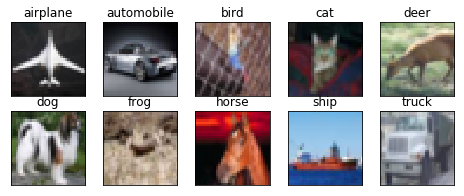

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [0]:
from keras.callbacks import LearningRateScheduler
from keras import regularizers

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 20:
        lrate = 0.0005
    if epoch > 30:
        lrate = 0.0003
    if epoch > 40:
      lrate = 0.00001
        
    return lrate

In [0]:
l2_reg_value= 0.0001

In [0]:
from keras.layers import Input, SeparableConv2D, DepthwiseConv2D, Concatenate
from keras.models import Model

#input layer 
visible = Input(shape=(32,32,3))

#add the input layer to the next normal convolution layer
# Normalize the convolution output , and apply drop out layer with value of 10%
conv1 = Convolution2D(32, kernel_size=3,border_mode='same', activation='relu',kernel_regularizer=regularizers.l2(l2_reg_value))(visible)
batch1 = BatchNormalization()(conv1)
drop1 = Dropout(0.1)(batch1)

# Using the input from previous dropout layer create seprable convolution with 3x1 and send that output to 1x3,
# which is same as 3x3 with less number of parameters. 
# Add ouput seprable convolution to normalization layer
seprable1 = Convolution2D(32,3,1, activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(l2_reg_value))(drop1) #30
seprable2 = Convolution2D(32,1,3, activation='relu',border_mode='same',kernel_regularizer=regularizers.l2(l2_reg_value))(seprable1) #30
batch2 = BatchNormalization()(seprable2)

# add pooling layer. connect BN output to pooling layer and its output to drop out layer with value 0.2
pool1 = MaxPooling2D(pool_size=(2, 2))(batch2)
drop3 = Dropout(0.2)(pool1)

# add deptwiseConv2D, which with depth_multiplier value as 4, which will add 4 times the input size as number of filters.
# direct output to BN and BN to dropout layer.
depthwise1 = SeparableConv2D(64, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(l2_reg_value))(drop3)
batch3 = BatchNormalization()(depthwise1)
drop4 = Dropout(0.25)(batch3)

# Add Group convolution.  We can combine 2 layers using Concatenate method of keras.  Ex: L1 and L2 can be added up to give  L3. 
# adding two 3x3 with 64 filters is equal to 128x3x3
# redirect grouped convolution output to BN.
conv3_1 = Convolution2D(64, (3, 3), activation='relu', padding='same',kernel_regularizer=regularizers.l2(l2_reg_value))(drop4)
conv3_2= Convolution2D(64, 5, 5, activation='relu', border_mode='same',kernel_regularizer=regularizers.l2(l2_reg_value)) (drop4)
group1= Concatenate()([conv3_1,conv3_2]) 
batch4 = BatchNormalization()(group1)

# add pooling layer and dropout to the network Graph.
pool2 = MaxPooling2D(pool_size=(2, 2))(batch4)
drop5 = Dropout(0.25)(pool2)

#Add Group convolution with dilation rate =1, which is nothing but normal 3x3  and dilation_rate=2 on to 5x5, which is equal to 3x3. 
# Combine those two into a group and add it to BN, followed by Dropout layer. 
conv4_1 = Convolution2D(64, 3, 3, activation='relu', dilation_rate=1,border_mode='same',kernel_regularizer=regularizers.l2(l2_reg_value) )(drop5)
conv4_2 = Convolution2D(64, 5, 5, activation='relu', dilation_rate=2, border_mode='same',kernel_regularizer=regularizers.l2(l2_reg_value))(drop5)
group2 = Concatenate()([conv4_1,conv4_2]) 
batch5 = BatchNormalization()(group2)
drop6 =  Dropout(0.25)(batch5)

# reduce the number channel from 128 to 32, so that number parameters gets reduced. 
# Hence we are attaching 1x1 to drop out and followed by a BN.
conv6 = Convolution2D(32, 1, 1,kernel_regularizer=regularizers.l2(l2_reg_value))(drop6)
batch7 = BatchNormalization()(conv6)  

# add a normal 3x3 layer to get the proper RF at the end. 
conv5 = Convolution2D(256, 3, 3,kernel_regularizer=regularizers.l2(l2_reg_value))(batch7)
batch6 = BatchNormalization()(conv5)  
drop7 =  Dropout(0.3)(batch6)                      

conv7 = Convolution2D(32, 1, 1,kernel_regularizer=regularizers.l2(l2_reg_value))(drop7)
batch8 = BatchNormalization()(conv7)  
drop8 =  Dropout(0.5)(batch8)

conv9 = Convolution2D(32, 3, 3,kernel_regularizer=regularizers.l2(l2_reg_value))(drop8)
batch10 = BatchNormalization()(conv9) 

# send only 10, 1x1 (as Global RF ) to flatten.  
conv10 = Convolution2D(10, 3, 3,kernel_regularizer=regularizers.l2(l2_reg_value))(batch10)
flat = Flatten()(conv10) 

# Connect the flatten layer output as input to softmax layer.
# Hence, at this point, the whole networ graph is there attached to the output layer.
output = Activation('softmax') (flat)

# Mention the input and output with  connected network layer to model. 
model = Model(inputs=visible, outputs=output)  

#compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, kernel_size=3, activation="relu", kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 1), activation="relu", kernel_regularizer=<keras.reg..., padding="same")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 3), activation="relu", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), activation="relu", kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Upd

In [0]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 32, 32, 32)   896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 32, 32, 32)   128         conv2d_28[0][0]                  
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 32, 32, 32)   0           batch_normalization_24[0][0]     
__________________________________________________________________________________________________
conv2d_29 

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':


Epoch 1/50
390/390 [==============================] - 21s 55ms/step - loss: 1.5242 - acc: 0.4673 - val_loss: 1.3384 - val_acc: 0.5737
Epoch 2/50
390/390 [==============================] - 16s 40ms/step - loss: 1.0788 - acc: 0.6394 - val_loss: 0.9620 - val_acc: 0.6900
Epoch 3/50
390/390 [==============================] - 15s 40ms/step - loss: 0.9013 - acc: 0.7096 - val_loss: 0.8712 - val_acc: 0.7342
Epoch 4/50
390/390 [==============================] - 16s 40ms/step - loss: 0.8126 - acc: 0.7425 - val_loss: 0.8977 - val_acc: 0.7295
Epoch 5/50
390/390 [==============================] - 16s 40ms/step - loss: 0.7539 - acc: 0.7665 - val_loss: 0.8030 - val_acc: 0.7655
Epoch 6/50
390/390 [==============================] - 16s 40ms/step - loss: 0.6982 - acc: 0.7910 - val_loss: 0.9138 - val_acc: 0.7418
Epoch 7/50
390/390 [==============================] - 16s 40ms/step - loss: 0.6652 - acc: 0.8057 - val_loss: 0.7248 - val_acc: 0.7897
Epoch 8/50
390/390 [==============================] - 16s 40ms

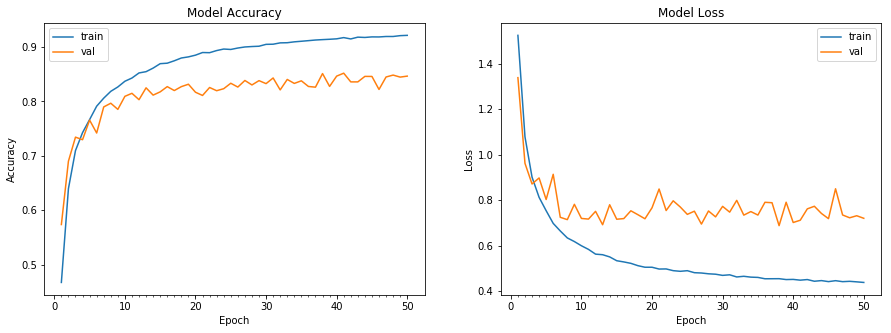

Accuracy on test data is: 84.63


In [0]:
# Train the network using the generator apis.
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy seems to be improved compared to the original model. The gap between training and validation accuracy is improved after adding the L2 = 0.0001, but still not similar to baseline model. The fluctuation in the loss hints something wrong... is it because of dilation_rate=2? Or is this because chosen value for L2?